# DNN MODEL BUILD

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Train and Test Datasets

In [6]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf


# Set dataset directory path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/"

# Load preprocessed train and test sets
train_df = pd.read_csv(dataset_path + "train.csv")
test_df = pd.read_csv(dataset_path + "test.csv")

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

Train dataset shape: (1515164, 16)
Test dataset shape: (726426, 16)


# Separate Features and Labels

In [9]:
# Identify feature columns (all except label columns)
label_column = 'Label'
feature_columns = [col for col in train_df.columns if col != label_column]

# Extract features (X) and labels (y)
X_train, y_train = train_df[feature_columns], train_df[label_column]
X_test, y_test = test_df[feature_columns], test_df[label_column]

# Encode labels into integer categories
y_train, label_encoder = pd.factorize(y_train)
y_test = label_encoder.get_indexer(y_test)

print(f"Feature columns: {len(feature_columns)}, Label classes: {len(label_encoder)}")
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print("Number of Feature used:", len(feature_columns))

Feature columns: 15, Label classes: 13
Training samples: 1515164, Testing samples: 726426
Number of Feature used: 15


# Define and Train the MLP Model

In [13]:
print("y_train shape:", y_train.shape)  # Should be (1515164,)
print("Unique labels in y_train:", np.unique(y_train))
print("Data type of y_train:", len(np.unique(y_train)))


y_train shape: (1515164,)
Unique labels in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Data type of y_train: 13


In [14]:
num_classes = len(np.unique(y_train))

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(len(feature_columns),)))  # Input layer
model.add(tf.keras.layers.Dense(len(feature_columns), activation='relu'))
model.add(tf.keras.layers.Dense(len(feature_columns), activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  # Output layer with 7 classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()


start = time.time()
history = model.fit(X_train, y_train, epochs=5, batch_size=1024, verbose=1)
end = time.time()
print(f'Elapsed Training Time: {(end - start)/60:.2f} minutes')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 15)                  │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 15)                  │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 13)                  │             208 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 688 (2.69 KB)

 Trainable params: 688 (2.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5282 - loss: 1.5382
Epoch 2/5
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6933 - loss: 0.8175
Epoch 3/5
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7723 - loss: 0.6714
Epoch 4/5
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8184 - loss: 0.5705
Epoch 5/5
1480/1480 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8507 - loss: 0.4962
Elapsed Training Time: 0.51 minutes


# Performance Predictions

In [15]:
start = time.time()
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred_proba = model.predict(X_test)  # Needed for AUC-ROC Score
end = time.time()

print(f'Elapsed Prediction Time: {(end - start)/60:.2f} minutes')


22701/22701 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
22701/22701 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
Elapsed Prediction Time: 1.27 minutes


# Generate Confusion Matrix

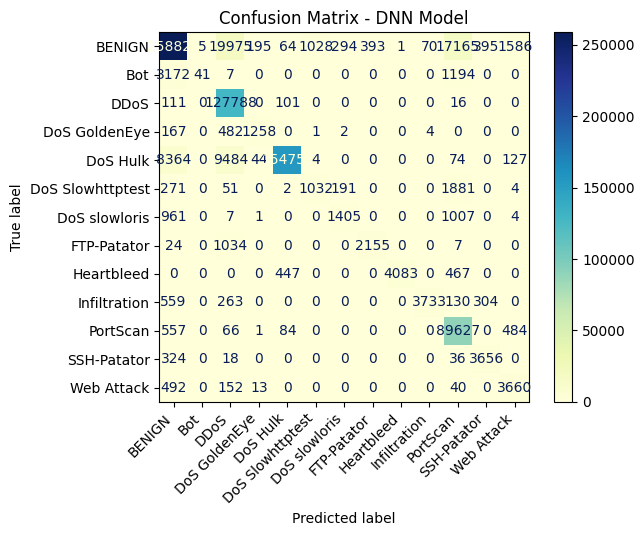


Classification Report:
                  precision    recall  f1-score   support

          BENIGN       0.95      0.86      0.90    300000
             Bot       0.89      0.01      0.02      4414
            DDoS       0.80      1.00      0.89    128016
   DoS GoldenEye       0.83      0.66      0.73      1914
        DoS Hulk       1.00      0.90      0.94    172849
DoS Slowhttptest       0.50      0.30      0.38      3432
   DoS slowloris       0.74      0.42      0.53      3385
     FTP-Patator       0.85      0.67      0.75      3220
      Heartbleed       1.00      0.82      0.90      4997
    Infiltration       0.98      0.75      0.85      4989
        PortScan       0.80      0.99      0.89     90819
     SSH-Patator       0.84      0.91      0.87      4034
      Web Attack       0.62      0.84      0.72      4357

        accuracy                           0.90    726426
       macro avg       0.83      0.70      0.72    726426
    weighted avg       0.91      0.90      0.9

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate Classification Report
# ✅ Load the saved LabelEncoder
encoder_path = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/label_encoder.pkl"
label_encoder = joblib.load(encoder_path)

# ✅ Convert class labels to strings
class_names = [str(cls) for cls in label_encoder.classes_]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='YlGnBu', values_format='d')

plt.title('Confusion Matrix - DNN Model')
plt.xticks(rotation=45, ha="right")
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Compute Performance Metrics

In [20]:
# Compute Accuracy, Precision, Recall, F1, BACC, and MCC
def ACC(TP, TN, FP, FN):
    return (TP + TN) / (TP + FP + FN + TN)

def PRECISION(TP, FP):
    return TP / (TP + FP) if (TP + FP) > 0 else 0

def RECALL(TP, FN):
    return TP / (TP + FN) if (TP + FN) > 0 else 0

def F1(Recall, Precision):
    return 2 * Recall * Precision / (Recall + Precision) if (Recall + Precision) > 0 else 0

def BACC(TP, TN, FP, FN):
    return (TP / (TP + FN) + TN / (TN + FP)) * 0.5

def MCC(TP, TN, FP, FN):

    TP, TN, FP, FN = map(np.float64, [TP, TN, FP, FN])

    numerator = (TN * TP - FN * FP)
    denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    if denominator == 0:
        return 0

    return np.clip(numerator / denominator, -1, 1)

# Extract True Positives, False Positives, False Negatives, and True Negatives
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Compute Metrics
Acc = ACC(sum(TP), sum(TN), sum(FP), sum(FN))
Precision = PRECISION(sum(TP), sum(FP))
Recall = RECALL(sum(TP), sum(FN))
F1_score = F1(Recall, Precision)
BACC_score = BACC(sum(TP), sum(TN), sum(FP), sum(FN))
MCC_score = MCC(sum(TP), sum(TN), sum(FP), sum(FN))

# Print Performance Metrics
print(f'Accuracy: {Acc:.4f}')
print(f'Precision: {Precision:.4f}')
print(f'Recall: {Recall:.4f}')
print(f'F1 Score: {F1_score:.4f}')
print(f'BACC: {BACC_score:.4f}')
print(f'MCC: {MCC_score:.4f}')

Accuracy: 0.9842
Precision: 0.8976
Recall: 0.8976
F1 Score: 0.8976
BACC: 0.9445
MCC: 0.8890


# AUC-ROC Score

In [17]:
y_test_binarized = label_binarize(y_test, classes=range(num_classes))
auc_score = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr")

print(f"AUC-ROC Score: {auc_score:.4f}")

AUC-ROC Score: 0.9684


# Save the Trained DNN Model

In [21]:
model_folder = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/"
model_filename = "CICIDS-2017_DNN.h5"
model_path = model_folder + model_filename

model.save(model_path)
print(f"DNN model saved to: {model_path}")

DNN model saved to: /content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/CICIDS-2017_DNN.h5
